# Data Modeling and analysis of OpenSky and JHU COVID-19 datasets

## Project Scope
COVID-19 pandemic has been one of the most significant events to affect mankind in recent history. Its impact on human lives and economies has been quite devastating. This project tries to explore the progression of COVID-19 in regions across the world and its impact on the airline industry. Airline industry can be broadly seen as an indicator of global commerce activity. Conversely, flight data can also be used to find patterns of spread across the regions through virus vectors aboard international flights. However, this might require more granular information and is out of scope of this project.

We will be using a flight dataset that tracks aircraft using ADS-B equipment around the world. We can aggregate the flight data to calculate incoming and outgoing traffic from each airport. We can then aggregate the airport data to region or country level and compare with COVID-19 data.


### Datasets
1. OpenSky COVID-19 Dataset - We will be modeling and aggregating flight data from OpenSky flight dataset.

https://opensky-network.org/community/blog/item/6-opensky-covid-19-flight-dataset

2. John Hopkins University Enigma Timeseries - For COVID-19, we will be using John Hopkins University's Enigma timeseries dataset available on AWS COVID-19 data lake.

https://aws.amazon.com/blogs/big-data/a-public-data-lake-for-analysis-of-covid-19-data/

3. Airports Dataset - We will also use an airport lookup dataset that will help us link airport codes to regions of the world.

4. Country Code Dataset - Airport dataset has countries listed in two digit ISO 3166-1 format, so we will also need a mapping from country codes to names to match with COVID dataset. We will be using the lookup from the following link.

https://datahub.io/core/country-list


The data can be downloaded by executing `data_downloader.py` script. Please note that the file name of COVID-19 data changes frequently as the dataset is regularly updated, so update the file name by visiting the datalake.

## Conceptual Data Model
Our motivation is to be able to identify daily air traffic into and out of airports and to relate the changes in traffic to COVID-19 trends and our knowledge of lockdowns across various parts of the world. From flight data, we will be deriving the daily domestic and international traffic for each airport. Since each airport can be uniquely identified by its code, we will use airport code and date to organize the traffic data.

For COVID data, each record will be uniquely identified by country, state, and admin region in addition to the date. Other information about the region can be stored in a dimension table.

We will have following tables in our data model.

- Airport traffic (fact table)
- Airport info (dimension table)
- Covid cases (fact table)
- Region info (dimension table)


In [1]:
# import required modules
import pandas as pd
import configparser
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import IntegerType
import clean
import etl

config = configparser.ConfigParser()
config.read('config.cfg')

%load_ext autoreload
%autoreload 2

In [2]:
# Read in the data
spark = SparkSession \
        .builder \
        .config("spark.jars.packages", "com.amazonaws:aws-java-sdk:1.7.3,org.apache.hadoop:hadoop-aws:2.7.3") \
        .getOrCreate()

# Opensky dataset (Local)
df_os_raw = spark.read.format('csv').option('header', 'true').load(config['DATA']['OPENSKY_FLIGHTS'])

# Airport codes dataset (Local)
df_airports_raw = spark.read.format('csv').option('header', 'true').load(config['DATA']['AIRPORT_CODES'])

# Country codes dataset (Local)
df_iban_raw = spark.read.format('json').load(config['DATA']['COUNTRY_CODES'])

# John Hopkins University COVID-19 dataset (Local)
df_covid_raw = spark.read.format('json').load(config['DATA']['COVID19_CASES'])

## Data cleanup
Based on our analysis in exploration notebook, we will drop some columns unnecessary for our model and then aggregate and filter the data. Inline comments below provide further details at each step.

In [3]:
df_flights = clean.clean_flights(df_os_raw)
print(f"number of flights  \t: {df_flights.count():9d}")

df_airports = clean.clean_airports(df_airports_raw)
print(f"number of airports \t: {df_airports.count():9d}")

df_iban = clean.clean_country_codes(df_iban_raw)
print(f"number of country codes : {df_iban.count():9d}")

df_covid = clean.clean_covid_data(df_covid_raw)
print(f"number of covid records : {df_covid.count():9d}")

number of flights  	:  14889687
number of airports 	:     55075
number of country codes :       249
number of covid records :    450597


## ETL Pipeline

In [4]:
df_airports = etl.airports_transform(df_airports, df_iban)

df_all_traffic = etl.flights_transform(df_flights, df_airports)

df_covid_fact = etl.covid_data_transform_fact(df_covid)

df_covid_dim = etl.covid_data_transform_dim(df_covid)

## Sample final data

In [5]:
# sample the data for Chicago O'Hare International Airport. This is our airport traffic fact table.
df_all_traffic.where(col('airport')=='KORD').orderBy('date').limit(10).toPandas()

,date,airport,domestic_inbound,domestic_outbound,international_inbound,international_outbound
0,2019-11-01,KORD,1173,1087,81,81
1,2019-11-02,KORD,1101,1057,79,81
2,2019-11-03,KORD,972,1004,74,78
3,2019-11-04,KORD,1194,1153,83,82
4,2019-11-05,KORD,1174,1146,71,81
5,2019-11-06,KORD,1155,1146,79,82
6,2019-11-07,KORD,1198,1160,85,87
7,2019-11-08,KORD,1196,1190,83,78
8,2019-11-09,KORD,1114,1082,81,82
9,2019-11-10,KORD,1038,1031,74,87


In [6]:
# take a sample from COVID dataset for Cook county, Illinois
df_covid_fact \
    .where(col('country')=='US') \
    .where(col('province_state')=='Illinois') \
    .where(col('admin2')=='Cook') \
    .limit(5).toPandas()

,date,country,province_state,admin2,confirmed,deaths,recovered
0,2020-01-22,US,Illinois,Cook,0,0,0
1,2020-01-23,US,Illinois,Cook,0,0,0
2,2020-01-24,US,Illinois,Cook,1,0,0
3,2020-01-25,US,Illinois,Cook,1,0,0
4,2020-01-26,US,Illinois,Cook,1,0,0


## Execute ETL pipeline

In [7]:
# save airport traffic fact table
df_all_traffic.write.format('parquet').save('outputs/airport_traffic')

# save airport information dimension
df_airports.write.format('parquet').save('outputs/airport_info')

# save covid fact data
df_covid_fact.write.format('parquet').save('outputs/covid_cases')

# save dimension data containing admin region information
df_covid_dim.write.format('parquet').save('outputs/covid_locations')

## Quality Check

In [8]:
import quality

# verify air traffic data
print("checking data quality for table airport_traffic")
df_all_traffic = spark.read.format('parquet').load('outputs/airport_traffic')
quality.assert_non_empty(df_all_traffic)
quality.assert_values(df_all_traffic, 'airport', ['KORD', 'KATL', 'KJFK', 'CYTZ'])

# verify airport info data
print("\nchecking data quality for table airport_info")
df_airports = spark.read.format('parquet').load('outputs/airport_info')
quality.assert_non_empty(df_airports)
quality.assert_values(df_airports, 'airport', ['KORD', 'KATL', 'KJFK', 'CYTZ'])
quality.assert_values(df_airports, 'country', ['Canada', 'India'])

# verify covid cases data
print("\nchecking data quality for table covid_cases")
df_covid = spark.read.format('parquet').load('outputs/covid_cases')
quality.assert_non_empty(df_covid)
quality.assert_values(df_covid, 'country', ['France', 'Australia'])
quality.assert_values(df_covid, 'province_state', ['Illinois', 'Florida'])

# verify covid region data
print("\nchecking data quality for table covid_locations")
df_covid_loc = spark.read.format('parquet').load('outputs/covid_locations')
quality.assert_non_empty(df_covid_loc)
quality.assert_values(df_covid_loc, 'country', ['Netherlands', 'Sweden'])
quality.assert_values(df_covid_loc, 'province_state', ['Victoria', 'Florida'])

checking data quality for table airport_traffic
record count :  985519, non-empty check passed
verified values ['KORD', 'KATL', 'KJFK', 'CYTZ'] in column airport

checking data quality for table airport_info
record count :   55062, non-empty check passed
verified values ['KORD', 'KATL', 'KJFK', 'CYTZ'] in column airport
verified values ['Canada', 'India'] in column country

checking data quality for table covid_cases
record count :  450597, non-empty check passed
verified values ['France', 'Australia'] in column country
verified values ['Illinois', 'Florida'] in column province_state

checking data quality for table covid_locations
record count :    3493, non-empty check passed
verified values ['Netherlands', 'Sweden'] in column country
verified values ['Victoria', 'Florida'] in column province_state


## Data Dictionary

### airport_traffic (fact)

|Field|Type|Description|
|:----|:---|:----------|
|date|date|traffic record date|
|airport|string|airport code|
|domestic_inbound|long|number of inbound domestic flights|
|domestic_outbound|long|number of outbound domestic flights|
|international_inbound|long|number of inbound international flights|
|international_outbound|long|number of outbound international flights|


### airport_info (dimension)

|Field|Type|Description|
|:----|:---|:----------|
|airport|string|airport code|
|type|string|airport type - large, medium, small etc.|
|name|string|public name of airport|
|country|string|country where airport is located|
|country_code|string|ISO 3166-1 code of the country|
|region|string|region where airport is located|
|continent|string|continent where airport is located|
|coordinates|string|coordinates of airport|

### covid_cases (fact)

|Field|Type|Description|
|:----|:---|:----------|
|date|date|date of record|
|country|string|country of record|
|province_state|string|province or state where cases are reported|
|admin2|string|admin region or county where cases are reported|
|confirmed|long|cumulative COVID-19 cases reported till date|
|deaths|long|cumulative COVID-19 deaths reported till date|
|recovered|long|cumulative recovered cases till date|

### covid_locations (dimension)

|Field|Type|Description|
|:----|:---|:----------|
|country|string|country of record|
|province_state|string|province or state where cases are reported|
|admin2|string|admin region or county where cases are reported|
|latitude|double|latitude of admin region or county|
|longitude|double|longitude of admin region or county|





## Data Analysis
Now we can finally join the traffic and COVID datasets together and do some basic analysis. We will be plotting the daily international traffic and cummulative case counts.

In [9]:
# aggregate traffic data to country level
# each domestic flight will be outbound for one airport and inbound for another, but should be counted as 1
# however, we see differences in the number of inbound and outbound flights for the same day. 
# This should be because of time zone differences and unreported data. Hence we can take the average of these two 
# and cast to nearest int.
df_country_traffic = df_all_traffic.join(df_airports, 'airport') \
    .groupBy('country', 'date') \
    .agg(
        sum('domestic_inbound').alias('domestic_inbound'),
        sum('domestic_outbound').alias('domestic_outbound'),
        sum('international_inbound').alias('international_inbound'),
        sum('international_outbound').alias('international_outbound'),
    ) \
    .withColumn('domestic', (col('domestic_inbound')+col('domestic_outbound'))/2) \
    .withColumn('domestic', col('domestic').cast(IntegerType())) \
    .drop('domestic_inbound', 'domestic_outbound')

# aggregate COVID data to country level
df_country_covid = df_covid.groupBy('country', 'date') \
    .agg(
        sum('confirmed').alias('confirmed'),
        sum('deaths').alias('deaths'),
        sum('recovered').alias('recovered')
    )

df_air_traffic_covid = df_country_traffic.join(df_country_covid, ['country', 'date'])

In [10]:
df_air_traffic_covid.limit(10).toPandas()

,country,date,international_inbound,international_outbound,domestic,confirmed,deaths,recovered
0,Austria,2020-02-23,314,308,84,0,0,0
1,Portugal,2020-03-02,315,314,110,2,0,0
2,Austria,2020-02-22,367,326,132,0,0,0
3,Belgium,2020-03-16,214,196,77,1058,5,1
4,Ireland,2020-05-21,22,23,27,24391,1583,21060
5,Philippines,2020-02-18,102,110,292,3,1,1
6,Norway,2020-02-29,127,132,151,15,0,0
7,Switzerland,2020-02-05,469,440,149,0,0,0
8,Philippines,2020-05-07,15,16,19,10343,685,1618
9,Ireland,2020-04-05,38,38,21,4994,158,25


<AxesSubplot:xlabel='date'>

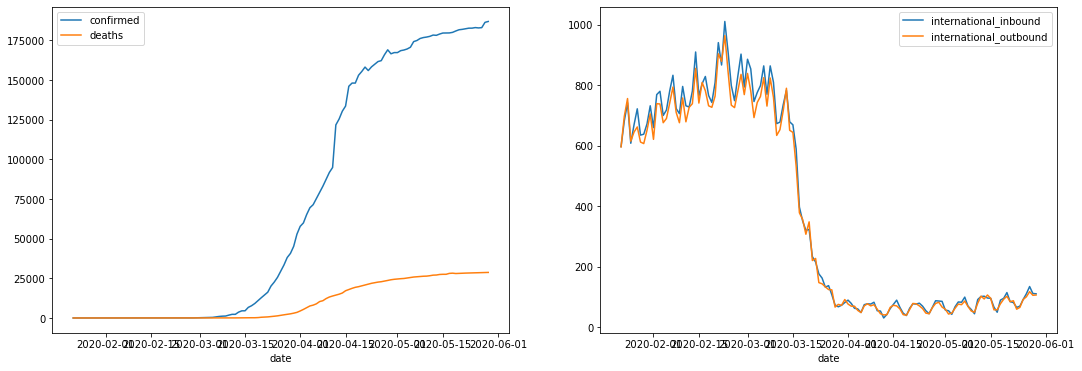

In [11]:
# we can plot the cumulative cases against air traffic of any country
import matplotlib.pyplot as plt
%matplotlib inline

country_data = df_air_traffic_covid.where(col('country')=='France').drop('recovered').toPandas()

fig, axes = plt.subplots(ncols=2, figsize=(18,6))
country_data.plot(x='date', y=['confirmed', 'deaths'], ax=axes[0])
country_data.plot(x='date', y=['international_inbound', 'international_outbound'], ax=axes[1])

We can see that after mid-March, the air traffic across the world dropped steeply as COVID-19 infections started rising. This matches with our knowledge of events as internation travel was limited and lockdowns were imposed during the same period.

## Pipeline Design

### Tools
Apache Spark was used as the tool for creating this pipeline because complicated data manipulations and joins were needed to aggregate the data. The initial flight data was around 15 million records. Hence, Spark is a perfect fit for this dataset and model.

### Data updates
The data in the dataset is aggregated at daily intervals. Hence the lowest update frequency is daily.

**The data was increased by 100x**

If data volume is increase, our pipeline will still work since its cluster based and can be scaled up. The Spark cluster can be run on Amazon EMR and scaled up to add more compute instances.

**The data populates a dashboard that must be updated on a daily basis by 7am every day**

We can automate the pipeline by using Apache Airflow. We can create a data pipeline that first downloads newest dataset files from OpenSky and COVID-19 files from AWS COVID-19 data lake. Alternatively, we can read the COVID data directly from S3 within Spark. After reading the data, a Spark operator can execute a python version of the Spark work we defined in this notebook.

**The database needed to be accessed by 100+ people**

We can save the parquet files in HDFS to support the traffic. As a better alternative, we can save the data in Amazon Redshift. We can even save the data in a conventional SQL database since the aggregated data is not that huge.

### Credits
Matthias Schäfer, Martin Strohmeier, Vincent Lenders, Ivan Martinovic and Matthias Wilhelm.
"Bringing Up OpenSky: A Large-scale ADS-B Sensor Network for Research".
In Proceedings of the 13th IEEE/ACM International Symposium on Information Processing in Sensor Networks (IPSN), pages 83-94, April 2014.